In [37]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re
from catboost import CatBoostRegressor
from sklearn.model_selection import KFold
from tqdm.notebook import tqdm

In [6]:
df = pd.read_csv('test.csv')
df1 = pd.read_csv('autoru2.csv')
pd.options.display.max_columns = 30
df1 = df1[0:7400]

In [7]:
df.drop(['vehicleConfiguration','description','name', 'brand', 'id', 'Комплектация'], axis = 1, inplace = True)
df1.drop(['Unnamed: 0', 'image', 'vehicleConfiguration','name', 'brand','availability', 'Комплектация','url', 'fuelType.1','name1','name2','priceCurrency'], axis = 1, inplace = True)

In [8]:
#from km in mile
df1.drop(df1[df1.kmage.isna() == True].index, axis = 0, inplace = True)
df1['mileage'] = df1.kmage.apply(lambda x: round(float(x[0:-7]+x[-6:-3])*0.62137))
df1.drop(['kmage'], axis = 1, inplace = True)

In [9]:
df['Владение'].fillna('не имел владельцев', inplace = True)
df1['Владение'].fillna('не имел владельцев', inplace = True)

In [10]:
df1 = df1.reset_index(drop=True)

In [12]:
num_feat = df1.select_dtypes(exclude = ['O']).copy()
cat_feat = df1.select_dtypes(include = ['O']).copy()

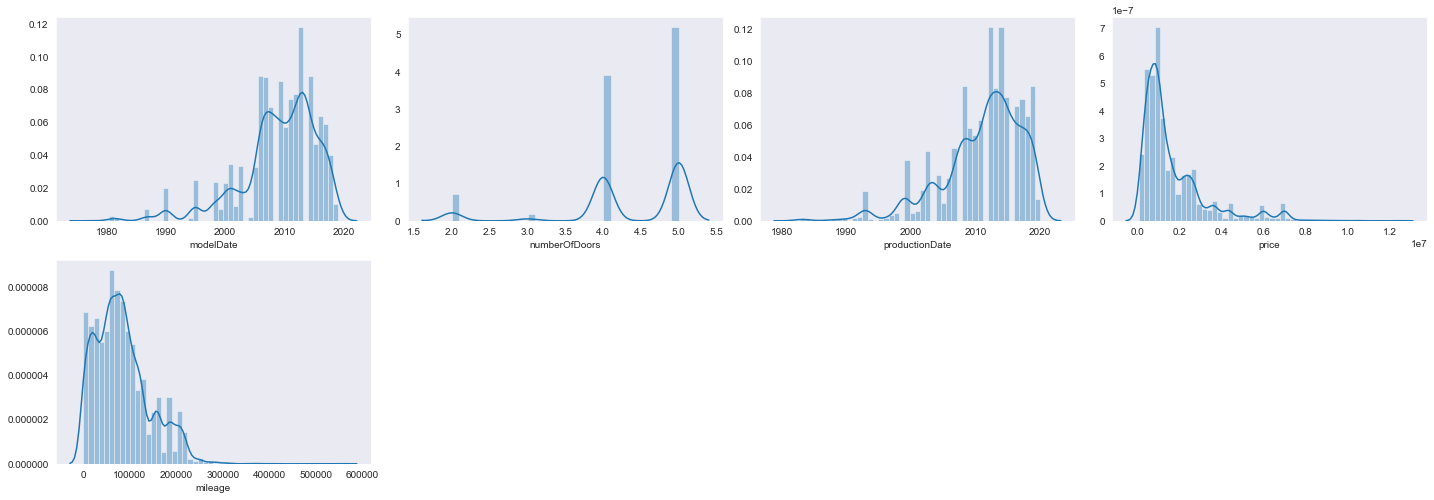

In [13]:
sns.set_style('dark')
fig = plt.figure(figsize = (20,10))
for index, col in enumerate(num_feat):
    plt.subplot(3,4, index+1)
    sns.distplot(num_feat.loc[:, col].dropna())
fig.tight_layout(pad = 1)

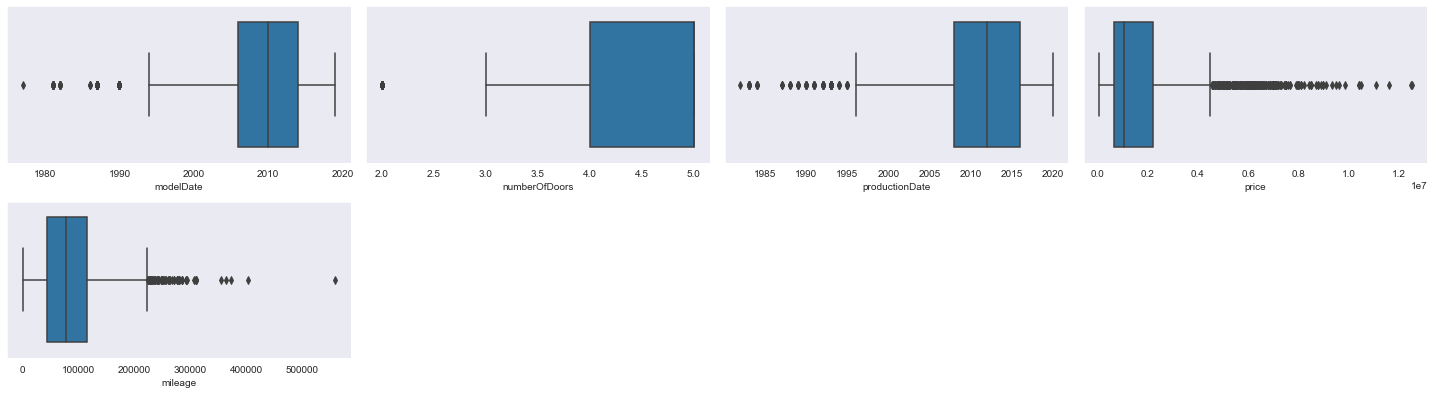

In [14]:
fig = plt.figure(figsize = (20,16))
for index, col in enumerate(num_feat):
    plt.subplot(6,4, index+1)
    sns.boxplot(num_feat.loc[:, col].dropna())
fig.tight_layout(pad = 1)

In [17]:
df1[df1.mileage >400000]

,bodyType,color,fuelType,modelDate,numberOfDoors,productionDate,vehicleTransmission,engineDisplacement,enginePower,Привод,Руль,Состояние,Владельцы,ПТС,Таможня,Владение,price,mileage
1965,седан,чёрный,бензин,1986.0,4.0,1988.0,автоматическая,3.0 LTR,188 N12,задний,Левый,Не требует ремонта,3 или более,Дубликат,Растаможен,не имел владельцев,105000.0,403890
2771,седан,серебристый,бензин,1987.0,4.0,1993.0,механическая,2.5 LTR,192 N12,задний,Левый,Не требует ремонта,3 или более,Оригинал,Растаможен,1 год и 1 месяц,180000.0,559233


In [18]:
df1 = df1.drop(df1[df1.mileage >400000].index)

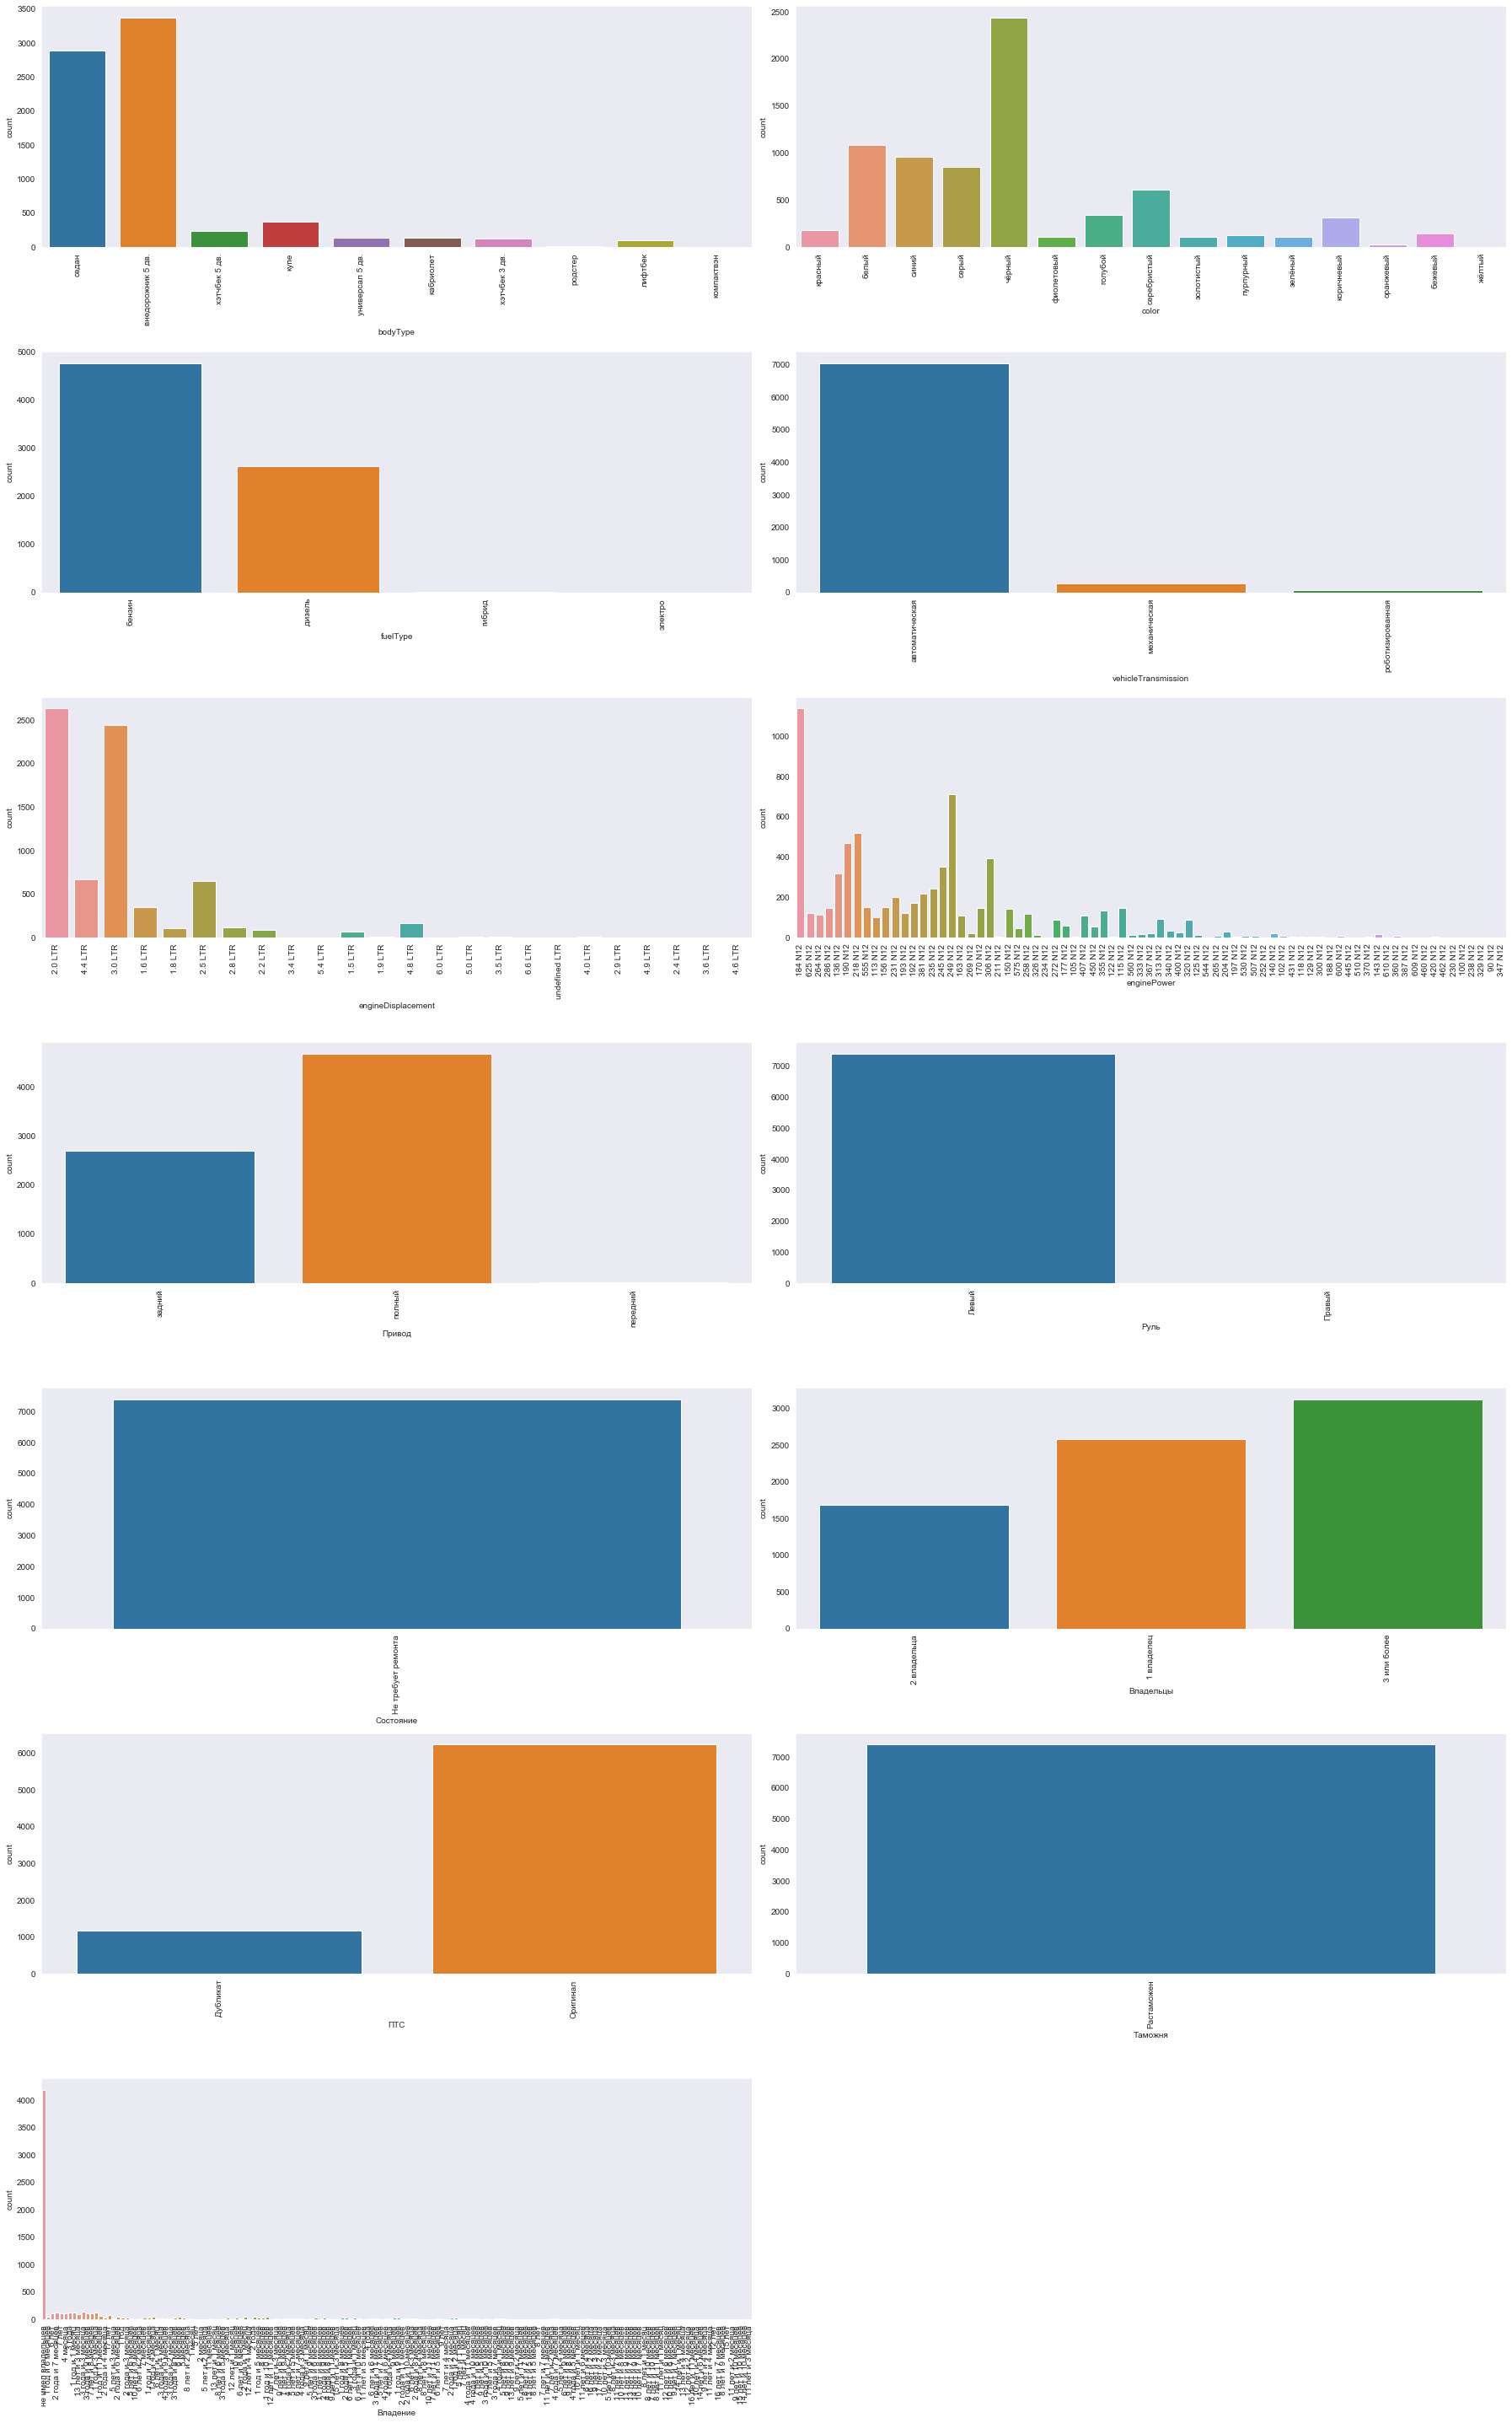

In [24]:
fig = plt.figure(figsize=(25,40))
for index in range(len(cat_feat.columns)):
    plt.subplot(7,2,index+1)
    sns.countplot(x=cat_feat.iloc[:,index], data=cat_feat.dropna())
    plt.xticks(rotation=90)
fig.tight_layout(pad=1.0)

In [26]:
df1['Привод'].value_counts()

полный      4672
задний      2703
передний      21
Name: Привод, dtype: int64

In [27]:
df1['fuelType'].value_counts()

бензин     4766
дизель     2619
гибрид        9
электро       2
Name: fuelType, dtype: int64

In [28]:
df1 = df1.drop(df1[df1['Привод'] == 'передний'].index)
df1 = df1.drop(df1[(df1['fuelType'] == 'гибрид') | (df1['fuelType'] == 'электро')].index)

In [31]:
df.drop(['Руль','Владение','Состояние'], axis = 1, inplace = True)
df1.drop(['Руль','Владение','Состояние'], axis = 1, inplace = True)

In [42]:
cat_feat = df1.select_dtypes(include = ['O']).copy()
for feat in cat_feat:
    df1[feat]=df1[feat].astype('str')
    df[feat]=df[feat].astype('str')
for feature in ['modelDate', 'numberOfDoors', 'mileage', 'productionDate']:
    df1[feature]=df1[feature].astype('int32')
    df[feature]=df[feature].astype('int32')

In [43]:
X = df1.drop(['price'], axis = 1)
y = df1['price']
cat_features_ids = np.where(X.apply(pd.Series.nunique) < 3000)[0].tolist()

In [44]:
y_real = pd.read_csv('sample_submission.csv')
sample_submission = y_real.copy()

In [45]:
def cat_model(y_train, X_train, X_test, y_test):
    model = CatBoostRegressor(iterations = 2000,
                              learning_rate = 0.1,
                              eval_metric='MAPE',
                              random_seed = 42)
    model.fit(X_train, y_train,
              cat_features=cat_features_ids,
              eval_set=(X_test, y_test),
              verbose=False,
              use_best_model=True,
              plot=False)
    
    return(model)


def mape(y_true, y_pred):
    return np.mean(np.abs((y_pred-y_true)/y_true))

In [49]:
X = df1.drop(['price'], axis = 1)
y = df1['price']
X = X.reset_index(drop=True)
y = y.reset_index(drop=True)

In [50]:
submissions = pd.DataFrame(0,columns=["sub_1"], index=sample_submission.index) # куда пишем предикты по каждой модели
score_ls = []
splits = list(KFold(n_splits=5, shuffle=True, random_state=42).split(X, y))

for idx, (train_idx, test_idx) in tqdm(enumerate(splits), total=5):
    # use the indexes to extract the folds in the train and validation data
    X_train, y_train, X_test, y_test = X.iloc[train_idx], y[train_idx], X.iloc[test_idx], y[test_idx]
    # model for this fold
    model = cat_model(y_train, X_train, X_test, y_test)
    # score model on test
    test_predict = model.predict(X_test)
    test_score = mape(y_test, test_predict)
    score_ls.append(test_score)
    print(f"{idx+1} Fold Test MAPE: {mape(y_test, test_predict):0.3f}")
    # submissions
    submissions[f'sub_{idx+1}'] = model.predict(df)
    model.save_model(f'catboost_fold_{idx+1}.model')
    
print(f'Mean Score: {np.mean(score_ls):0.3f}')
print(f'Std Score: {np.std(score_ls):0.4f}')
print(f'Max Score: {np.max(score_ls):0.3f}')
print(f'Min Score: {np.min(score_ls):0.3f}')

1 Fold Test MAPE: 0.087
2 Fold Test MAPE: 0.091
3 Fold Test MAPE: 0.082
4 Fold Test MAPE: 0.080
5 Fold Test MAPE: 0.076

Mean Score: 0.083
Std Score: 0.0055
Max Score: 0.091
Min Score: 0.076


In [51]:
submissions['blend'] = (submissions.sum(axis=1))/len(submissions.columns)
sample_submission['price'] = submissions['blend'].values

In [52]:
sample_submission

,id,price
0,0,1.996456e+06
1,1,2.333239e+06
2,2,1.246605e+06
3,3,2.378350e+06
4,4,4.689221e+06
...,...,...
3832,3832,1.138903e+06
3833,3833,2.935675e+06
3834,3834,6.072308e+05
3835,3835,1.023310e+06


In [53]:
mape(y_real.price, sample_submission.price)

1.1019518491844962

In [54]:
submission_blend = pd.read_csv('submission_blend.csv')

In [55]:
submission_blend

,id,price
0,0,1.889652e+06
1,1,2.323680e+06
2,2,1.283343e+06
3,3,2.316761e+06
4,4,4.716469e+06
...,...,...
3832,3832,1.122068e+06
3833,3833,2.816895e+06
3834,3834,6.026882e+05
3835,3835,1.015126e+06


In [56]:
mape(y_real.price, submission_blend.price)

1.108642789585679